# **Emotion Detection using Fine-Tuned BERT**
**Name:** Diya Amith Kodappully  
**Student ID:** 22071849

### **Assignment 2 - Individual project - Large language models (97PAM2015-0509-2024)**   

## **Introduction**
In this notebook, I fine-tune a pre-trained BERT model to classify emotions in text. Language models like BERT understand human language by learning patterns in large text datasets. I chose the task of emotion classification because understanding emotions in text is important in many real-world applications like mental health support, chatbots, and content moderation.

I used the `emotion` dataset from Hugging Face, performed data exploration, applied tokenization, and fine-tuned the model using class weights to address label imbalance. Finally, I evaluated the model and tested it on new text inputs.



In [ ]:
!pip install transformers datasets evaluate scikit-learn

In [ ]:
pip install --upgrade transformers

In [ ]:
pip install --upgrade datasets

## **Initial Loading**

In [1]:
#Import Libraries
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, f1_score
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import BertPreTrainedModel, BertModel


In [2]:
# Load dataset

def load_emotion_dataset():
    dataset = load_dataset("emotion")
    return dataset

In [3]:
dataset = load_emotion_dataset()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [45]:
# Print total number of rows per split

print("Number of rows:")
for split in dataset:
    print(f"{split}: {len(dataset[split])}")

Number of rows:
train: 16000
validation: 2000
test: 2000


## **Exploratory Data Analysis**

In [4]:
# EDA

def run_eda(dataset):
    # Convert train split to DataFrame
    df = pd.DataFrame(dataset["train"])

    # Label mapping
    label_names = dataset["train"].features["label"].names
    df["label_name"] = df["label"].apply(lambda x: label_names[x])

    # Print first few lines
    print("📋 First 5 rows of the training dataset:")
    print(df.head(), "\n")

    # Plot label distribution
    plt.figure(figsize=(8,5))
    sns.countplot(x="label_name", data=df, order=label_names, palette="Set2")
    plt.title("Distribution of Emotion Labels in Training Data")
    plt.xticks(rotation=45)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Text length distribution
    df["text_length"] = df["text"].apply(lambda x: len(x.split()))
    plt.figure(figsize=(8,5))
    sns.histplot(df["text_length"], bins=30, kde=True)
    plt.title("Text Length Distribution (in words)")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Print one example from each class
    print("📝 Sample texts by emotion label:")
    for label in label_names:
        sample = df[df["label_name"] == label].sample(1).iloc[0]
        print(f"{label}: {sample['text']}")


📋 First 5 rows of the training dataset:
                                                text  label label_name
0                            i didnt feel humiliated      0    sadness
1  i can go from feeling so hopeless to so damned...      0    sadness
2   im grabbing a minute to post i feel greedy wrong      3      anger
3  i am ever feeling nostalgic about the fireplac...      2       love
4                               i am feeling grouchy      3      anger 



/tmp/ipython-input-4-3554643719.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label_name", data=df, order=label_names, palette="Set2")


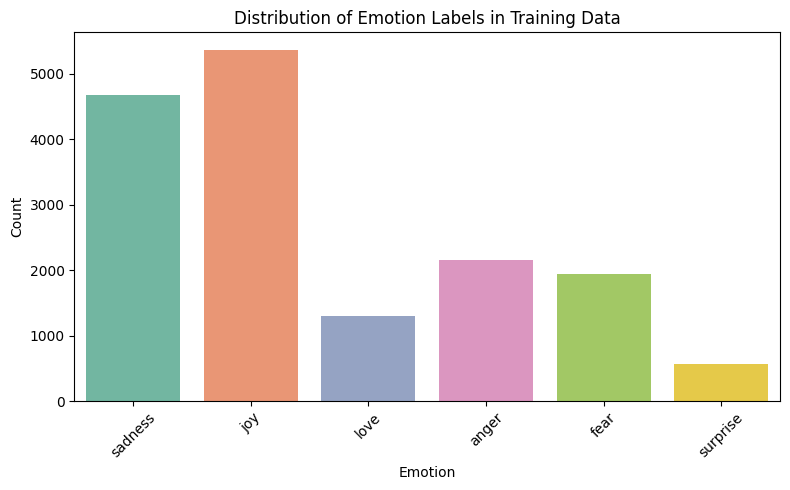

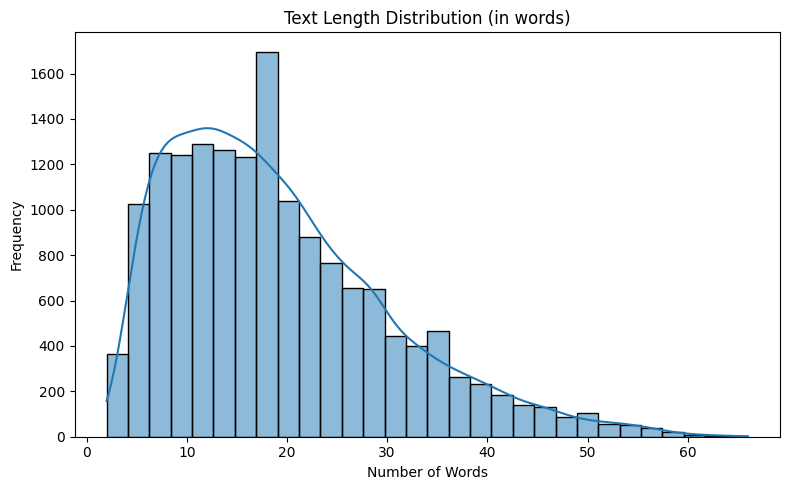

📝 Sample texts by emotion label:
sadness: i still miss him and feel rather weepy today
joy: i just think it is so quirky and the other day i was not feeling along with a few of the kiddos so daniel being his sweetheart considerate self went and got me this movie
love: i feel more of a sense of longing than of loss
anger: i hate talking about presents because i feel greedy
fear: i drove to class i was feeling a little apprehensive but still no sweat
surprise: im sure youre not alone in feeling a little funny about enjoying art even black created and black endorsed art littered with a term that would brand you as hateful backward and racist with a capital r if you uttered it in conversation


In [5]:
run_eda(dataset)

## **Compute Class Weights**

In [6]:
# Assign balanced class weights to address class imbalance in training set

def get_class_weights(dataset):
    labels = np.array(dataset["train"]["label"])
    unique_labels = np.unique(labels)
    class_weights = compute_class_weight(class_weight="balanced", classes=unique_labels, y=labels)
    return torch.tensor(class_weights, dtype=torch.float)


## **Tokenization**

In [1]:
# BERT's tokenizer to tokenize the text with padding and truncation

def tokenize_and_prepare(dataset):
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    def tokenize(batch):
        return tokenizer(batch['text'], padding=True, truncation=True)
    dataset = dataset.map(tokenize, batched=True, batch_size=None)
    dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    return dataset, tokenizer

In [8]:
dataset, tokenizer = tokenize_and_prepare(dataset)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [9]:
# compute metrics

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

## **Fine Tuned BERT model**

In [10]:
# Extend HuggingFace's BertPreTrainedModel
# Add dropout, classification head
# Use CrossEntropyLoss with computed class weights

class WeightedBERTForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.class_weights = class_weights

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs[1])
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}


## **Model Training**

In [11]:
# Configure Trainer API with:
# - Epochs, learning rate, batch size
# - Logging, evaluation strategy
# - Save best model based on evaluation metrics

def train_model(dataset, tokenizer, epochs=4, batch_size=16, learning_rate=5e-5):
    class_weights = get_class_weights(dataset)

    model = WeightedBERTForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=6, class_weights=class_weights
    )

    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=64,
        learning_rate=learning_rate,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True,
        save_total_limit=1,
        report_to=[]
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        compute_metrics=compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()
    val_acc = metrics.get("eval_accuracy", 0)
    print(f"Epochs: {epochs}, Batch size: {batch_size}, LR: {learning_rate}, Val Acc: {val_acc:.4f}")

    return trainer, model  # Return both if you want to unpack later


In [12]:
trainer, model = train_model(dataset, tokenizer)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of WeightedBERTForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.236500,0.168740,0.928000
2,0.103900,0.204499,0.936000
3,0.098200,0.216385,0.936000
4,0.103800,0.319975,0.938500


Epochs: 4, Batch size: 16, LR: 5e-05, Val Acc: 0.9280


## **Plot Training Logs**

In [13]:
# Extract and plot training loss and validation accuracy from Trainer logs
# Helps visualize learning progress

def plot_training_logs(trainer):
    logs = trainer.state.log_history
    train_loss, eval_accuracy, eval_steps = [], [], []

    for entry in logs:
        if "loss" in entry:
            train_loss.append(entry["loss"])
        if "eval_accuracy" in entry:
            eval_accuracy.append(entry["eval_accuracy"])
            eval_steps.append(entry["step"])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(eval_steps, eval_accuracy, label="Eval Accuracy", color='orange')
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Eval Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

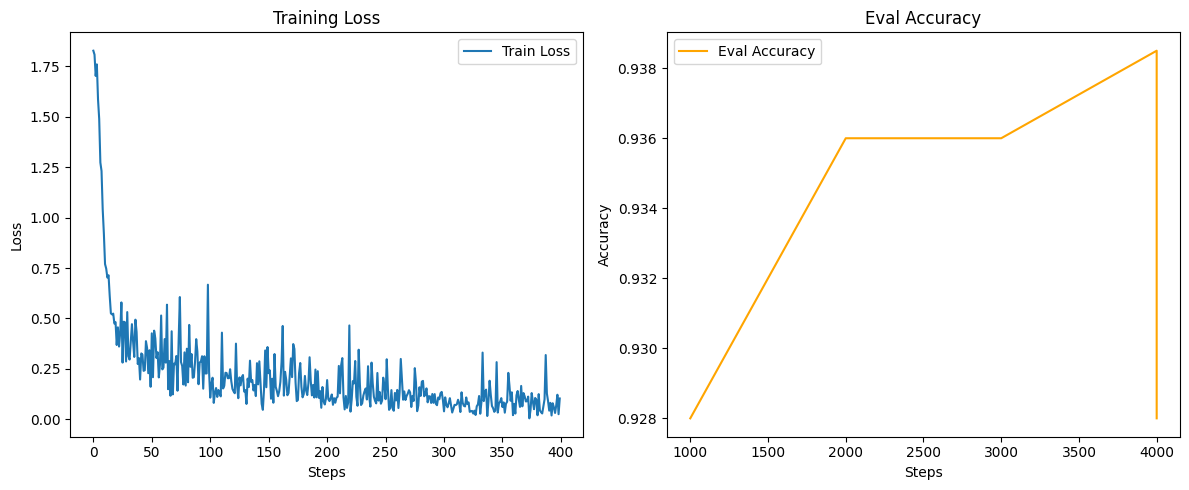

In [14]:
plot_training_logs(trainer)

In [24]:
# Save the trained model and tokenizer for reuse or inference

trainer.save_model("./fine_tuned_bert_emotion")
tokenizer.save_pretrained("./fine_tuned_bert_emotion")


('./fine_tuned_bert_emotion/tokenizer_config.json',
 './fine_tuned_bert_emotion/special_tokens_map.json',
 './fine_tuned_bert_emotion/vocab.txt',
 './fine_tuned_bert_emotion/added_tokens.json',
 './fine_tuned_bert_emotion/tokenizer.json')

## **Evaluate on Test Set**

In [16]:
# Evaluate trained model on test set
# Print classification report for precision, recall, F1 per class

def evaluate_model(trainer, dataset):
    results = trainer.evaluate(dataset["test"])
    print("Test set results:", results)

    predictions = trainer.predict(dataset["test"])
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=dataset["train"].features["label"].names))

In [17]:
evaluate_model(trainer, dataset)

Test set results: {'eval_loss': 0.20538857579231262, 'eval_accuracy': 0.9245, 'eval_runtime': 1.646, 'eval_samples_per_second': 1215.068, 'eval_steps_per_second': 19.441, 'epoch': 4.0}
Classification Report:

              precision    recall  f1-score   support

     sadness       0.98      0.95      0.96       581
         joy       0.99      0.90      0.94       695
        love       0.73      0.97      0.84       159
       anger       0.90      0.97      0.93       275
        fear       0.92      0.85      0.88       224
    surprise       0.65      0.94      0.77        66

    accuracy                           0.92      2000
   macro avg       0.86      0.93      0.89      2000
weighted avg       0.94      0.92      0.93      2000



In [38]:
# Load saved model + tokenizer into a pipeline

def load_pipeline():
    model_path = "./fine_tuned_bert_emotion"
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Label mapping
    id2label = {
        0: "sadness",
        1: "joy",
        2: "love",
        3: "anger",
        4: "fear",
        5: "surprise"
    }

    model.config.id2label = id2label
    model.config.label2id = {v: k for k, v in id2label.items()}

    classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)
    return classifier, id2label


In [41]:
# Predict emotion for custom input sentences

def emotion_Predicted(classifier, id2label, texts):
    for text in texts:
        result = classifier(text)[0]
        emotion = result['label']
        score = result['score']
        print(f"Sentence: {text}\nPredicted emotion: {emotion} (confidence: {score:.2f})\n")


In [44]:
# Predict on custom texts

classifier, id2label = load_pipeline()
test_texts = [
        "I am so happy today!",
        "This is so scary and frightening.",
        "I feel angry about what happened.",
        "I'm really surprised by the news!",
        "She looks very sad and down."
       ]
emotion_Predicted(classifier, id2label, test_texts)

Device set to use cuda:0


Sentence: I am so happy today!
Predicted emotion: joy (confidence: 0.83)

Sentence: This is so scary and frightening.
Predicted emotion: fear (confidence: 0.49)

Sentence: I feel angry about what happened.
Predicted emotion: anger (confidence: 0.98)

Sentence: I'm really surprised by the news!
Predicted emotion: surprise (confidence: 1.00)

Sentence: She looks very sad and down.
Predicted emotion: sadness (confidence: 0.99)

